# Preprocessing of Calcium signals

In [134]:
import numpy as np

from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import gaussian_filter1d # for gaussian smoothing

import os

In [140]:
# data visualization module
from datavyz import gen as ge

## Loading the data produced by Suite2P

In [141]:
# parameters of the data analyzed here

data_params = {
    # acquisition frequency
    'freq_acq' : 30., # Hz
}

In [142]:
data_directory = '/home/yann/Downloads/Ca_data/'

folders  = [os.path.join(data_directory, d) for d in os.listdir(data_directory)]
print('Data available in the directory: "%s"' % data_directory)
for i, f in enumerate(os.listdir(data_directory)):
    print('%i) %s' % (i+1, f))

Data available in the directory: "/home/yann/Downloads/Ca_data/"
1) TSeries-061119_58-0087-002
2) TSeries-061119_58-0001-001


In [143]:
# we load the data produced by Suite2P
def load_data_from_folder(folder,
                          soft_prefix='suite2p',
                          plane_prefix='plane0'):

    data = {}
    for key in ['F', 'stat', 'iscell', 'Fneu']:
        data[key] = np.load(os.path.join(folder, soft_prefix, plane_prefix, '%s.npy' % key), allow_pickle=True)

    return data

data = load_data_from_folder(folders[0])

## Preprocessing parameters

In [144]:
preprocessing_params = {
    # fraction to be multiplied to neurpil for substraction from contaminated fluorescence
    'fraction_of_substracted_neuropil':0.7, # unitless
    # threshold to be applied 
    'percentile_threshold_for_baseline': 20, # unitless
    # window length for calculating delta F over F
    'sliding_window_for_baseline' : 10, # seconds
    # factor that the Ca-trace of a cell should exceed wrt to neuropil signal to be classified as a cell
    'fluo_factor_wrt_neuropil_for_inclusion':1.5, # unitless
}

In [153]:
from scipy.ndimage.filters import gaussian_filter1d # for gaussian smoothing

# numpy code for ~efficiently evaluating the distrib percentile over a sliding window
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))


def sliding_percentile(array, percentile, Window):

    x = np.zeros(len(array))
    y0 = strided_app(array, Window, 1)

    y = np.percentile(y0, percentile, axis=-1)
    
    x[:int(Window/2)] = y[0]
    x[-int(Window/2):] = y[-1]
    x[int(Window/2)-1:-int(Window/2)] = y
    
    return x


def from_raw_data_to_deltaFoverF(folder,
                                 freq_acq=30.,
                                 fraction_of_substracted_neuropil=0.7,
                                 percentile_threshold_for_baseline=0.2,
                                 sliding_window_for_baseline = 30.,
                                 fluo_factor_wrt_neuropil_for_inclusion = 1.5,
                                 verbose=False):

    if verbose:
        data = load_data_from_folder(folder)
        print(' data from: "%s" succesfully loaded ' % folder)

    print('----> Pre-processing the fluorescence of n=%i ROIs across n=%i time samples' % data['F'].shape)
    
    if verbose:
        print(' 1) [...] applying the ROI selection and the neuropil criteria')
    data['neuropil_cond'] = (np.mean(data['F'], axis=1)>fluo_factor_wrt_neuropil_for_inclusion*np.mean(data['Fneu'], axis=1))
    data['iscell'] = np.array(data['iscell'][:,0], dtype=bool)
    iscell = data['iscell'] & data['neuropil_cond']
    data['fluo_valid_cells'] = data['F'][iscell,:]
    print('----> n=%i ROIs are considered as valid cells' % np.sum(iscell))
    print
    
    if verbose:
        print(' 2) [...] substracting neuropil contamination')
    data['fluo_valid_cells'] -= fraction_of_substracted_neuropil*data['Fneu'][iscell,:]

    
    if verbose:
        print(' 3) [...] calculating sliding baseline per cell')
    Twidth = int(sliding_window_for_baseline*freq_acq) # window in sample units 
    # sliding minimum using the max filter of scipy, followed by gaussian smoothing
    data['sliding_min'] = 0*data['fluo_valid_cells']
    Twidth = int(sliding_window_for_baseline*freq_acq)
    for icell in range(data['fluo_valid_cells'].shape[0]):
        data['sliding_min'][icell,:] = gaussian_filter1d(\
                   sliding_percentile(data['fluo_valid_cells'][icell,:],
                                      percentile_threshold_for_baseline,
                                      Twidth), Twidth)
        
    if verbose:
        print(' 4) [...] performing DeltaF/F normalization')
    data['dFoF'] = np.divide((data['fluo_valid_cells']-data['sliding_min']),data['sliding_min'])

    # some useful quantites
    data['t'] = np.arange(int(data['fluo_valid_cells'].shape[1]))/freq_acq # time axis

    # formatted data
    Data = {}
    data['mean_Data'], data['std_Data'], data['norm_Data'] = {}, {}, {}
    
    for i in range(data['fluo_valid_cells'].shape[0]):
        key = 'cell%i' % (i+1)
        Data[key] = data['dFoF'][i, :]
        data['mean_Data'][key] = Data[key].mean()
        data['std_Data'][key] = Data[key].std()
        data['norm_Data'][key] = (Data[key]-Data[key].mean())/Data[key].std()
    if verbose:
        print('----> Pre-processing done !')

    return data, Data


In [154]:
data, Data = from_raw_data_to_deltaFoverF(folders[0],
                                          **data_params, **preprocessing_params, 
                                          verbose=True)

 data from: "/home/yann/Downloads/Ca_data/TSeries-061119_58-0087-002" succesfully loaded 
----> Pre-processing the fluorescence of n=173 ROIs across n=9074 time samples
 1) [...] applying the ROI selection and the neuropil criteria
----> n=10 ROIs are considered as valid cells
 2) [...] substracting neuropil contamination
 3) [...] calculating sliding baseline per cell
 4) [...] performing DeltaF/F normalization
----> Pre-processing done !


# visualizing pre-processing

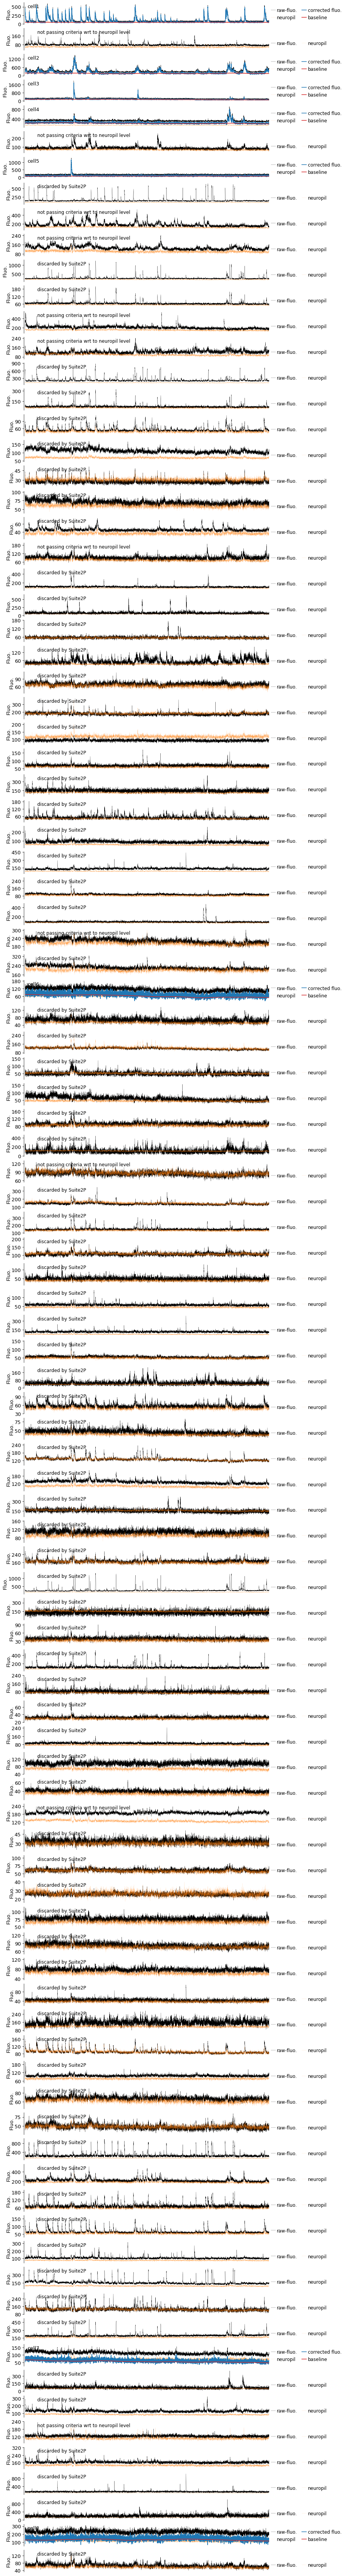

In [158]:
n = 100
fig, AX = ge.figure(axes=(1, n), figsize=(2,.5), hspace=0.3)
c=0
for i, ax in enumerate(AX):
    ax.plot(data['t'], data['F'][i,:], color='k', lw=0.3, label='raw-fluo.')
    ax.plot(data['t'], data['Fneu'][i,:], color=ge.orange, lw=0.1, label='neuropil')
    if data['iscell'][i] and data['neuropil_cond'][i]:
        ge.annotate(ax, 'cell%i' % (c+1), (.01,.7))
        ax.plot(data['t'], data['fluo_valid_cells'][c,:], label='corrected fluo.')
        ax.plot(data['t'], data['sliding_min'][c,:], label='baseline', color=ge.red)
        c+=1
    if not data['iscell'][i]:
        ge.annotate(ax, 'discarded by Suite2P', (0.05, .7), size='small')
    elif not data['neuropil_cond'][i]:
        ge.annotate(ax, 'not passing criteria wrt to neuropil level', (0.05, .7), size='small')
    ge.legend(ax, loc=(1.,.1), size='small', ncol=2)
    ge.set_plot(ax, ['left'], xlim=[data['t'][0], data['t'][-1]], ylabel='Fluo.')


In [156]:

def activity_plot(Data,
                  Data_original=None, t=None,
                  tzoom=[0, np.inf],
                  colors = None,
                  ax=None, bar_fraction=0.7, Tbar=10, lw=0.5):

    if ax is None:
        _, ax = ge.figure(axes_extents=(4,4))

    if colors is None:
        colors = [ge.colors[i%10] for i, k in enumerate(Data)]
        
    keys = [key for key in Data]
    if t is None:
        t = np.arange(len(Data[keys[0]]))
    t_cond = (t>=tzoom[0]) & (t>=tzoom[0])

    for i, key in enumerate(Data):
        if Data_original is not None:
            norm_factor = 1./(np.max(Data_original[key][t_cond])-np.min(Data_original[key][t_cond]))
            baseline = np.min(Data_original[key][t_cond])
            norm_Data_original = (Data_original[key][t_cond]-baseline)*norm_factor
            ax.plot(t[t_cond], i+norm_Data_original, colors[i], lw=0.2, alpha=.3)
        else:
            norm_factor = 1./(np.max(Data[key][t_cond])-np.min(Data[key][t_cond]))
            baseline = np.min(Data[key][t_cond]) 
           
        norm_Data = norm_factor*(Data[key][t_cond]-baseline)

        ax.plot(t[t_cond], i+norm_Data, colors[i], lw=lw)
        ge.annotate(ax, key, (t[t_cond][-1], i+1), color=colors[i],
                    xycoords='data', ha='right', size='small', va='top')
        
        # scale for that cell
        ax.plot([0, 0], [i, i+bar_fraction], color=ge.default_color)
        if 100.*norm_factor<1:
            ge.annotate(ax, '%.1f%%' % (100.*norm_factor),
                    (0, i), rotation=90, xycoords='data', ha='right', size='small')
        else:
            ge.annotate(ax, '%i%%' % int(100.*norm_factor),
                    (0, i), rotation=90, xycoords='data', ha='right', size='small')
        
    ax.plot([0, Tbar], [i+1, i+1], color=ge.default_color)
    ge.annotate(ax, '%is' % Tbar, (0, i+1), xycoords='data', size='small')
    
    ax.axis('off')
    return fig, ax

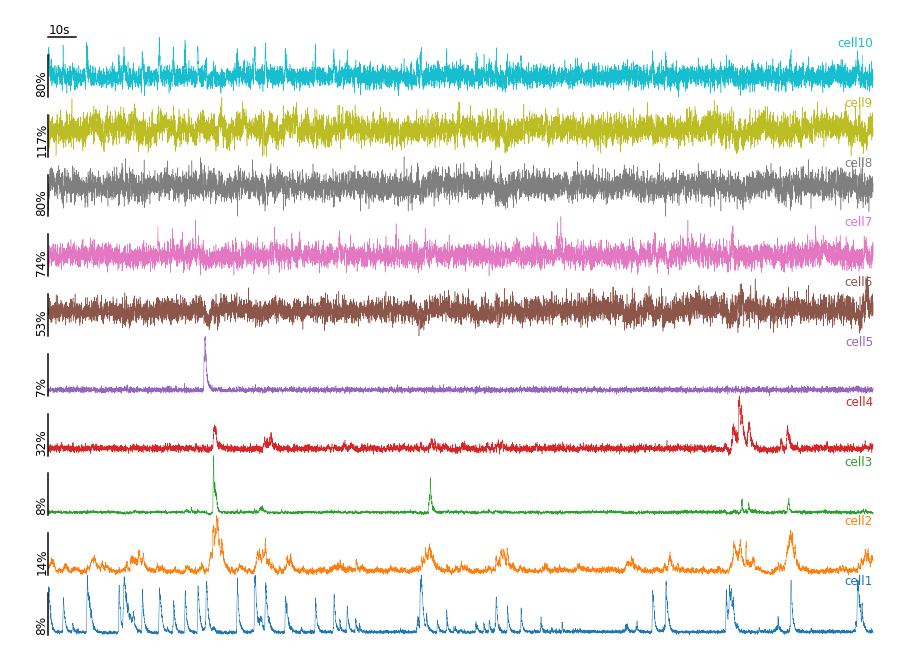

In [157]:
activity_plot(Data, Tbar=10, t=data['t']);